# Baysian Staggered DiD

In [39]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from patsy import dmatrix
import pymc as pm
import arviz as az
az.style.use('arviz-darkgrid')

In [73]:
filepath = '../../../../../data/processed/df_filtered.xlsx'
df = pd.read_excel(filepath)
df

,island_names,years,island_ids,region_codes,region_names,prefecture_codes,populations,treatment_group,treatment_group_mainland,year_bridges_opened,...,cohort_2000,years_cohort_2000,cohort_2004,years_cohort_2004,cohort_2011,years_cohort_2011,cohort_2015,years_cohort_2015,cohort_2016,years_cohort_2016
0,鹿久居島,1975,68,33342,日生町,33,46,1,1,2015,...,0,0,0,0,0,0,1,-40,0,0
1,鹿久居島,1980,68,33342,日生町,33,52,1,1,2015,...,0,0,0,0,0,0,1,-35,0,0
2,鹿久居島,1985,68,33342,日生町,33,53,1,1,2015,...,0,0,0,0,0,0,1,-30,0,0
3,鹿久居島,1990,68,33342,日生町,33,54,1,1,2015,...,0,0,0,0,0,0,1,-25,0,0
4,鹿久居島,1995,68,33342,日生町,33,45,1,1,2015,...,0,0,0,0,0,0,1,-20,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,戸島,2000,218,38203,宇和島市,38,451,0,0,0,...,0,0,0,0,0,0,0,0,0,0
596,戸島,2005,218,38203,宇和島市,38,473,0,0,0,...,0,0,0,0,0,0,0,0,0,0
597,戸島,2010,218,38203,宇和島市,38,414,0,0,0,...,0,0,0,0,0,0,0,0,0,0
598,戸島,2015,218,38203,宇和島市,38,344,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## TWFE

$$
\mu_{it} = \text{island}_i + \text{year}_t + \sum_{g \in G} \mu_g \mathbf{1} \{t-E_i \in g\} + \epsilon_{it}
$$

- $\text{island}_i$:
  - 個体効果
- $\text{year}_t$:
  - 年効果
- $E_i$:
  - 処置開始年

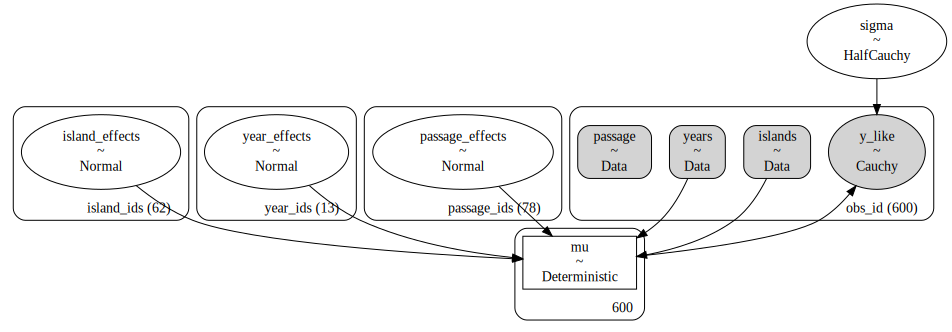

In [77]:
# 経過期間ダミーを作成
passages = dmatrix('C(passage_of_year)', data=df, return_type='dataframe')

# 0から始まるインデックスを振り直す
df['island_ids'], unique_island_ids = pd.factorize(df['island_ids'])
df['years'], unique_years = pd.factorize(df['years'])

# 次元の定義
coords = {
    'island_ids': unique_island_ids,
    'year_ids': unique_years,
    'passage_ids': df['passage_of_year'].unique(),
    'obs_id': df.index
}

with pm.Model(coords=coords) as twfe:
    # data
    islands = pm.Data('islands', df['island_ids'], dims='obs_id')
    years = pm.Data('years', df['years'], dims='obs_id')
    passage = pm.Data('passage', df['passage_of_year'], dims='obs_id')

    # priors
    island_effects = pm.Normal('island_effects', mu=0, sigma=100, dims='island_ids')
    year_effects = pm.Normal('year_effects', mu=0, sigma=100, dims='year_ids')
    passage_effects = pm.Normal('passage_effects', mu=0, sigma=100, dims='passage_ids')

    # model error
    sigma = pm.HalfCauchy('sigma', beta=1000000)

    # expectation
    mu = pm.Deterministic('mu', island_effects[islands] + year_effects[years] + pm.math.dot(passages, passage_effects))

    # likelihood
    y_like = pm.Cauchy('y_like', alpha=mu, beta=sigma, observed=df['population_change_rate'].values, dims='obs_id')

pm.model_to_graphviz(twfe)

In [78]:
with twfe:
    idata_twfe = pm.sample(draws=3000, tune=2000, nuts_sampler='numpyro', random_seed=123)

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [81]:
az.to_netcdf(idata_twfe, 'sample_baysian_did_twfe.nc')

'sample_baysian_did_twfe.nc'

In [82]:
az.summary(idata_twfe)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
island_effects[0],4.489,15.278,-24.002,33.120,0.572,0.405,713.0,1458.0,1.0
island_effects[1],1.487,14.612,-25.649,29.337,0.571,0.404,655.0,1273.0,1.0
island_effects[2],-1.284,26.041,-49.022,47.872,0.654,0.462,1587.0,2937.0,1.0
island_effects[3],9.649,16.171,-20.417,39.879,0.579,0.410,780.0,1954.0,1.0
island_effects[4],-5.570,14.589,-32.059,22.478,0.572,0.404,652.0,1224.0,1.0
...,...,...,...,...,...,...,...,...,...
mu[595],-12.858,2.021,-16.799,-9.227,0.019,0.013,11887.0,9462.0,1.0
mu[596],-5.206,2.436,-9.708,-0.582,0.023,0.016,11715.0,10697.0,1.0
mu[597],-13.372,1.972,-17.036,-9.650,0.018,0.013,12004.0,9821.0,1.0
mu[598],-13.351,2.147,-17.212,-9.273,0.020,0.014,11926.0,9985.0,1.0


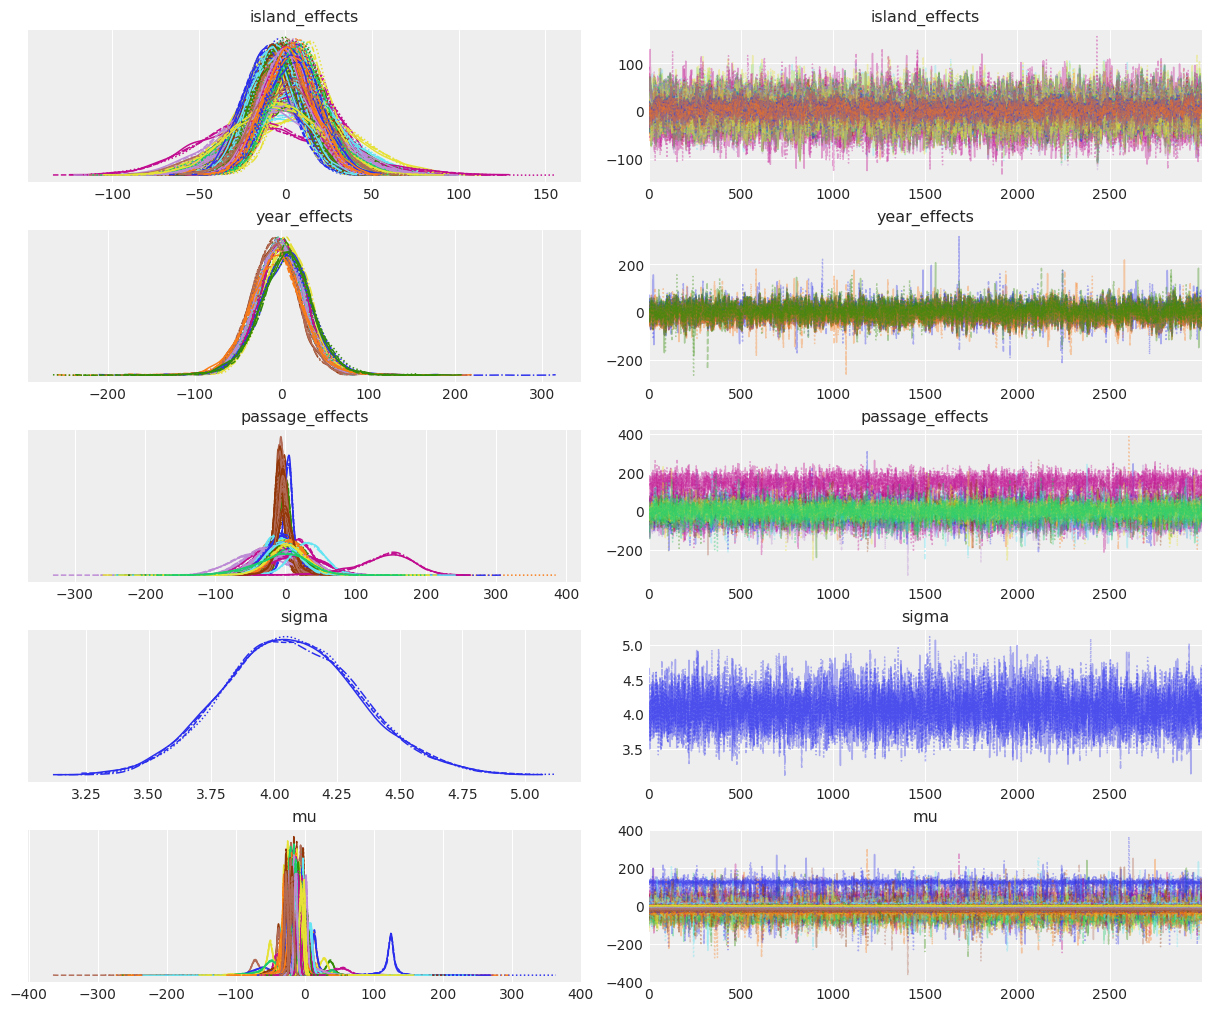

In [83]:
az.plot_trace(idata_twfe);

In [107]:
summary = az.summary(idata_twfe, var_names=['passage_effects'], hdi_prob=.95)
df_passage_effects = summary.reset_index()
# 数値部分を取り出す関数
def extract_number(index_str):
    match = re.search(r'\[(.*?)\]', index_str)
    return int(match.group(1)) if match else None

# 数値部分を新しい列として追加
df_passage_effects['passage_years'] = df_passage_effects['index'].apply(extract_number)
df_passage_effects.sort_values('passage_years', inplace=True)

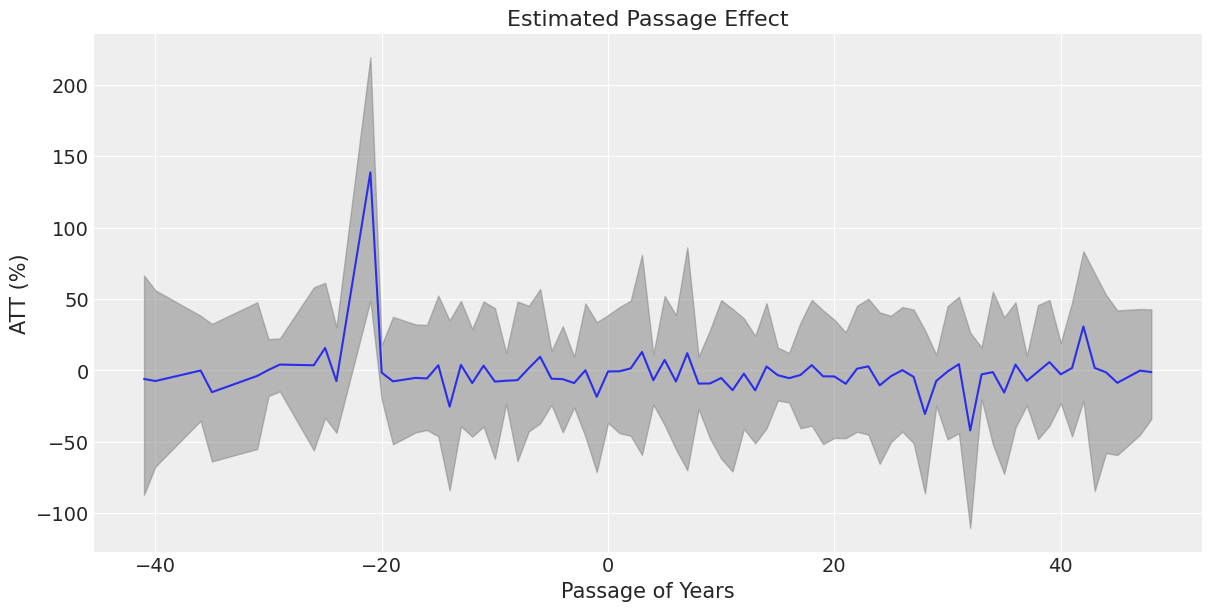

In [106]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='passage_years', y='mean', data=df_passage_effects)
plt.fill_between(
    df_passage_effects['passage_years'],
    df_passage_effects['hdi_2.5%'],
    df_passage_effects['hdi_97.5%'],
    color='gray', alpha=0.5, label='95% HDI'
)
plt.title('Estimated Passage Effect')
plt.xlabel('Passage of Years')
plt.ylabel('ATT (%)')
plt.show()

### Staggered DiD

$$
\mu_{it} = \text{TreatmentGroup} + \text{Year}_t + \text{PassageOfYear} \times \text{Cohort}
$$

$$
\mu_{it} = \beta_c + \sum_{g \in G} \beta_{group} \cdot 1(g_i = g) + \gamma_{year} + \sum_{k \geq 0} \delta_k \cdot D_{it}^k
$$

- $\beta_c$:
  - 基本の切片（元の式と同様）
- $\sum_{g \in G} \beta_g \cdot 1(g_i = g)$:
  - グループ固定効果
  - $G$は処置時期の集合
  - $1(g_i = g)$はグループ$g$に属する場合1となる指示関数
  - 処置タイミングでグループを分類
- $\gamma_{year}$:
  - 年固定効果（元の式の$\text{trend}_t \cdot t_i$をより柔軟に）
- $\sum_{k \geq 0} \delta_k \cdot D_{it}^k$:
  - 処置効果
  - $k$は処置からの経過期間
  - $D_{it}^k$は単位$i$が時点$t$で処置から$k$期経過している場合1となる指示関数

$$
\mu_{it} = \alpha_i + \gamma_t + \sum_{g \in G} \sum_{k \geq 0} \delta_{gk} \cdot 1(g_i = g) \cdot D_{it}^k
$$

In [16]:
with pm.Model() as model:
    # data

    # Priors
    treatment_group = pm.Normal('treatment_group', mu=0, sigma=100)
    beta_cohort_passage = pm.Normal('beta_cohort_passage', mu=0, sigma=100, shape=(n_cohort))
    islands_effects = pm.Normal('islands_effects', mu=0, sigma=100, shape=n_islands, dims='islands')
    years_effects = pm.Normal('years_effects', mu=0, sigma=100, shape=n_years, dims='years')
    sigma = pm.InverseGamma('sigma', alpha=0.001, beta=0.001)

    # expectation
    mu = pm.Deterministic('mu', outcome(), dims='obs_idx')

    # Likelihood
    pm.Normal('obs', mu=mu, sigma=sigma, observed=y, dims='obs_idx')

# モデルの視覚化
pm.model_to_graphviz(model)

TypeError: outcome() missing 7 required positional arguments: 't', 'control_intercept', 'treat_intercept_delta', 'trend', 'Δ', 'group', and 'treated'

In [28]:
with model:
    idata = pm.sample(
        draws=8000,
        tune=2000,
        nuts_sampler="numpyro",
        return_inferencedata=True,
        init="adapt_diag",
    )

ValueError: Incompatible Elemwise input shapes [(20,), (97,)]

In [62]:
az.to_netcdf(idata, 'bm_twfe.nc')

'bm_twfe.nc'

In [26]:
az.summary(idata, hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_treatment,-3.731,27.274,-55.413,50.194,0.471,0.333,3363.0,4742.0,1.00
beta_passage[0],7.528,24.204,-40.440,53.893,0.354,0.251,4661.0,8913.0,1.00
beta_passage[1],-17.364,21.225,-57.692,25.130,0.383,0.271,3072.0,7081.0,1.00
beta_passage[2],7.019,22.914,-37.262,51.786,0.351,0.248,4262.0,7799.0,1.00
beta_passage[3],13.954,21.353,-29.198,54.281,0.387,0.273,3054.0,6924.0,1.00
...,...,...,...,...,...,...,...,...,...
years_effects[9],1.577,19.456,-36.253,39.910,0.390,0.276,2490.0,4207.0,1.01
years_effects[10],-6.787,19.445,-44.335,31.908,0.390,0.276,2489.0,4097.0,1.01
years_effects[11],-7.472,19.441,-45.777,30.460,0.389,0.275,2500.0,4265.0,1.01
years_effects[12],-11.945,19.439,-50.192,26.125,0.389,0.275,2504.0,4190.0,1.01


In [55]:
az.summary(idata, var_names=['beta_passage'], hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_passage[0],7.528,24.204,-40.440,53.893,0.354,0.251,4661.0,8913.0,1.0
beta_passage[1],-17.364,21.225,-57.692,25.130,0.383,0.271,3072.0,7081.0,1.0
beta_passage[2],7.019,22.914,-37.262,51.786,0.351,0.248,4262.0,7799.0,1.0
beta_passage[3],13.954,21.353,-29.198,54.281,0.387,0.273,3054.0,6924.0,1.0
beta_passage[4],4.555,22.877,-39.731,49.686,0.352,0.249,4241.0,8052.0,1.0
...,...,...,...,...,...,...,...,...,...
beta_passage[72],-1.720,26.063,-52.498,49.621,0.364,0.257,5124.0,8332.0,1.0
beta_passage[73],3.309,24.861,-44.217,53.456,0.349,0.247,5064.0,9333.0,1.0
beta_passage[74],-5.735,22.198,-49.198,37.708,0.364,0.258,3712.0,8398.0,1.0
beta_passage[75],2.865,25.969,-48.746,53.053,0.362,0.256,5151.0,8712.0,1.0


array([[<Axes: title={'center': 'beta_treatment'}>,
        <Axes: title={'center': 'beta_treatment'}>],
       [<Axes: title={'center': 'beta_passage'}>,
        <Axes: title={'center': 'beta_passage'}>],
       [<Axes: title={'center': 'islands_effects'}>,
        <Axes: title={'center': 'islands_effects'}>],
       [<Axes: title={'center': 'years_effects'}>,
        <Axes: title={'center': 'years_effects'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

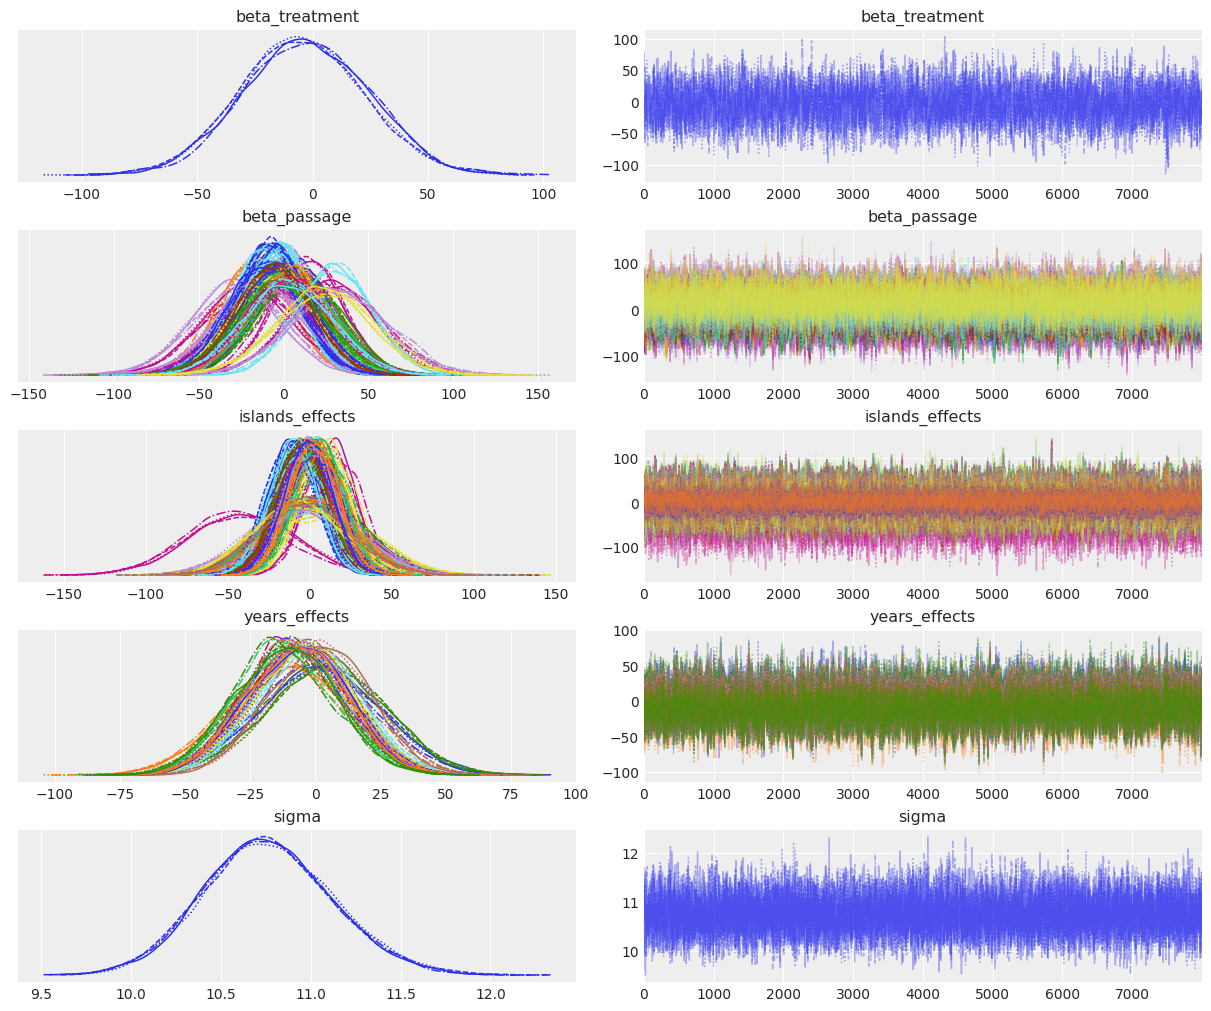

In [27]:
az.plot_trace(idata)

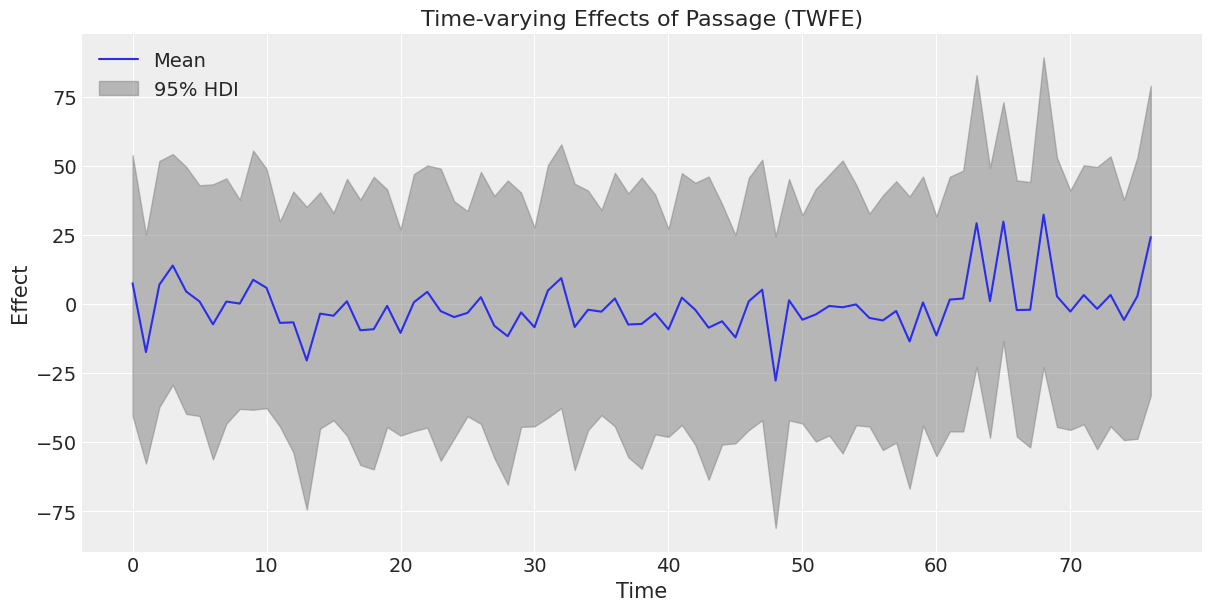

In [ ]:
# beta_passageの事後分布を抽出
beta_passage_posterior = idata.posterior['beta_passage']

# 事後分布の平均と信用区間を計算
beta_passage_mean = beta_passage_posterior.mean(dim=["chain", "draw"]).values
beta_passage_hdi = az.hdi(beta_passage_posterior, hdi_prob=0.95)

# HDIの下限と上限を抽出
beta_passage_hdi_lower = beta_passage_hdi.sel(hdi='lower').to_array().values.flatten()
beta_passage_hdi_upper = beta_passage_hdi.sel(hdi='higher').to_array().values.flatten()

# プロットの作成
plt.figure(figsize=(12, 6))
plt.plot(beta_passage_mean, label='Mean')
plt.fill_between(
    range(len(beta_passage_mean)),
    beta_passage_hdi_lower,
    beta_passage_hdi_upper,
    color='gray', alpha=0.5, label='95% HDI'
)

plt.xlabel('Time')
plt.ylabel('Effect')
plt.title('Time-varying Effects of Passage (TWFE)')
plt.legend()
plt.show()

In [6]:
idata = az.from_netcdf('./bm_twfe_sampling.nc')

In [8]:
posterior_samples = idata.posterior

# 0以上のサンプルの割合を計算
prob_beta_bridge_positive = np.mean(posterior_samples['beta_passage'] > 0)
print(f"Pr(beta_passage > 0) = {prob_beta_bridge_positive:.4f}")
prob_sigma_positive = np.mean(posterior_samples['sigma'] > 0)
print(f"Pr(sigma > 0) = {prob_sigma_positive:.4f}")

Pr(beta_passage > 0) = 0.4786
Pr(sigma > 0) = 1.0000
